In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import io
import re
import time
import jieba
import pathlib
import unicodedata

from sklearn.model_selection import train_test_split

## Download and prepare the dataset

In [2]:
path_to_file = '/home/kaimo/.keras/datasets/cmn-eng/cmn.txt'

In [3]:
!head {path_to_file}

Hi.	嗨。	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #891077 (Martha)
Hi.	你好。	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4857568 (musclegirlxyp)
Run.	你用跑的。	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #3748344 (egg0073)
Wait!	等等！	CC-BY 2.0 (France) Attribution: tatoeba.org #1744314 (belgavox) & #4970122 (wzhd)
Wait!	等一下！	CC-BY 2.0 (France) Attribution: tatoeba.org #1744314 (belgavox) & #5092613 (mirrorvan)
Hello!	你好。	CC-BY 2.0 (France) Attribution: tatoeba.org #373330 (CK) & #4857568 (musclegirlxyp)
I try.	让我来。	CC-BY 2.0 (France) Attribution: tatoeba.org #20776 (CK) & #5092185 (mirrorvan)
I won!	我赢了。	CC-BY 2.0 (France) Attribution: tatoeba.org #2005192 (CK) & #5102367 (mirrorvan)
Oh no!	不会吧。	CC-BY 2.0 (France) Attribution: tatoeba.org #1299275 (CK) & #5092475 (mirrorvan)
Cheers!	乾杯!	CC-BY 2.0 (France) Attribution: tatoeba.org #487006 (human600) & #765577 (Martha)


In [4]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [5]:
# preprocess sentence
def preprocess_sentence(s, is_chinese):
    s = unicode_to_ascii(s.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    s = re.sub(r"([?.!,¿])", r" \1 ", s) # "\1" represents the first matched group, used here for seperating punctuation
    s = re.sub(r'[" "]+', " ", s)

#     # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
#     s = re.sub(r"[^a-zA-Z?.!,¿]+", " ", s)

    s = s.strip()
    
    if is_chinese:
        # use jieba chinese tokenizer
        s = ' '.join(list(jieba.cut(s, cut_all=False)))

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    s = '<start> ' + s + ' <end>'
    return s

In [6]:
en_sentence = u"May I borrow this book?"
cn_sentence = u"你用跑的。"
print(preprocess_sentence(en_sentence, is_chinese=False))
print(preprocess_sentence(cn_sentence, is_chinese=True).encode('utf-8'))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.693 seconds.


<start> may i borrow this book ? <end>


Prefix dict has been built successfully.


b'<start> \xe4\xbd\xa0 \xe7\x94\xa8 \xe8\xb7\x91 \xe7\x9a\x84 \xe3\x80\x82 <end>'


In [7]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, CHINESE]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='utf-8').read().strip().split('\n')
    word_pairs = [(preprocess_sentence(l.split('\t')[0], is_chinese=False),
                   preprocess_sentence(l.split('\t')[1], is_chinese=True))
                  for l in lines[:num_examples]]
    return zip(*word_pairs)

In [8]:
en, cn = create_dataset(path_to_file, None)

In [9]:
list(zip(en[:5], cn[:5]))

[('<start> hi . <end>', '<start> 嗨 。 <end>'),
 ('<start> hi . <end>', '<start> 你好 。 <end>'),
 ('<start> run . <end>', '<start> 你 用 跑 的 。 <end>'),
 ('<start> wait ! <end>', '<start> 等等 ！ <end>'),
 ('<start> wait ! <end>', '<start> 等 一下 ！ <end>')]

In [10]:
def tokenize(texts):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(texts)
    
    tensor = lang_tokenizer.texts_to_sequences(texts)
    # Pad to the longest sequence
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

In [11]:
def load_dataset(path, num_examples=None):
    # Creating cleaned input, output pairs
    inp_lang, targ_lang = create_dataset(path, num_examples)
    
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [12]:
input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer = load_dataset(path_to_file, None)
# Calculating max_length of the target & input tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [13]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=.2)
print(len(input_tensor_train), len(input_tensor_val), len(target_tensor_train), len(target_tensor_val))

17660 4415 17660 4415


In [16]:
def convert(lang, tensor):
    """Convert index to word use lang(tokenizer)"""
    for idx in tensor:
        if idx != 0:
            print("{:d} ----> {:s}".format(idx, lang.index_word[idx]))

print ("Input Language; index to word mapping")
convert(inp_lang_tokenizer, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang_tokenizer, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
1309 ----> here's
27 ----> your
448 ----> tea
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
34 ----> 这
11 ----> 是
7 ----> 你
5 ----> 的
567 ----> 茶
3 ----> 。
2 ----> <end>


### Create a tf.data dataset

In [17]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang_tokenizer.word_index) + 1 # +1 for padding 0
vocab_targ_size = len(targ_lang_tokenizer.word_index) + 1

dataset = (
    tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
)

In [18]:
for i in dataset.take(1):
    print(i[0].shape, i[1].shape)

(64, 36) (64, 32)


## Write the encoder and decoder model

In [19]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.enc_units,
            return_sequences=True,
            return_state=True, # Whether to return the last state in addition to the output.
            recurrent_initializer='glorot_uniform'
        )
        
    def call(self, x, initial_state):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=initial_state)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros(shape=(self.batch_size, self.enc_units))

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [21]:
# Sample input
sample_hidden = encoder.initialize_hidden_state()
for i in dataset.take(1):
    sample_input_batch, _ = i
    sample_output, sample_hidden_state = encoder(sample_input_batch, sample_hidden)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

# Hidden state is the last output of returned sequence tensors
# sample_output[:, -1, :] == sample_hidden_state

Encoder output shape: (batch size, sequence length, units) (64, 36, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


This tutorial use __Bahdanau attention__ for the encoder.

- FC = Full connected (dense) layer
- EO = Encoder output (key & value)
- H = Hidden state (query)
- X = input to the decoder

And the pseudo-code:

- `score = FC(tanh(FC(EO) + FC(H)))`
- `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the 1st axis, since the shape of score is (batch_size, max_length, hidden_size). Max_length is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
- `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
- `embedding output` = The input to the decoder X is passed through an embedding layer.
- `merged vector` = concat(embedding output, context vector)
- This merged vector is then given to the GRU

In [22]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        # `query` hidden state shape == [BATCH_SIZE, hidden_size], from Decoder's one timestep hidden state
        # `query_with_time_axis` shape == [BATCH_SIZE, 1, hidden_size]
        # values shape == [BATCH_SIZE, max_len, hidden state], from Encoder's returned sequence hidden states
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)
        
        # score shape == [BATCH_SIZE, max_length, 1]
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is [BATCH_SIZE, max_length, units]
        _FC_H = self.W1(query_with_time_axis) # FC_H of shape [BATCH_SIZE, 1, units]
        _FC_EO = self.W2(values) # FC_EO of shape[BATCH_SIZE, max_length, units]
        _tanh = tf.nn.tanh(_FC_H + _FC_EO) # _tanh of shape [BATCH_SIZE, max_length, units]
        score = self.V(_tanh) # score of shape [BATCH_SIZE, max_length, 1]
        
        # attension_weights shape == [BACH_SIZE, max_length, 1]
        attention_weights = tf.nn.softmax(score, axis=1) # apply on time dimension
        
        # context_vector shape after sum == [BATCH_SIZE, hidden_size]
        context_vector = attention_weights * values # of shape [BATCH_SIZE, max_length, hidden_size]
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [23]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 36, 1)


In [28]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.attention = BahdanauAttention(1000) # 1000 is attention fc layer units size
        
    def call(self, x, dec_hidden, enc_output):
        """Call function for decoder.
        Args:
            x: decoder input, of shape [BATCH_SIZE, 1], every time only feed one word
            dec_hidden: decoder's hidden state, of shape [BATCH_SIZE, dec_hidden_size]
            enc_outputs: encoder's output sequence states, of shape [BATCH_SIZE, max_length, enc_hidden_size]
        """
        # enc_output shape == [BATCH_SIZE, max_length, hidden_size]
        # the attention use previous decoder's hidden state as query
        context_vector, attention_weights = self.attention(query=dec_hidden, values=enc_output)

        # x shape after passing through embedding == [BATCH_SIZE, 1, embedding_dim]
        x = self.embedding(x)
        
        # x shape after concattenation == [BATCH_SIZE, 1, hidden_size + embedding_dim] (hidden_size of Encoder)
        x = tf.concat([tf.expand_dims(context_vector, axis=1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, dec_hidden = self.gru(x)
        
        # output shape == [BATCH_SIZE * 1, hidden_size]
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == [BATCH_SIZE, vocab]
        x = self.fc(output)
        
        return x, dec_hidden, attention_weights

In [29]:
decoder = Decoder(vocab_targ_size, embedding_dim, units, BATCH_SIZE)

In [30]:
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

print('Decoder output shape: (bach_size, vocab_size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (bach_size, vocab_size) (64, 14055)


## Define the optimizer and loss function

In [31]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    """Calculate loss.
    Args:
        real: ground true, of shape [BATCH_SIZE,]
        pred: predictions, of shape [BATCH_SIZE, vocab_size]
        
    Returns:
        A scalar mean loss on batch_size
    """
    
    loss_ = loss_object(real, pred) # of shape [BATCH_SIZE,]
    # exclude the 0 padding
    mask = tf.cast(tf.math.not_equal(real, 0), loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

## Checkpoints(Object-based saving)

In [32]:
checkpoint_dir = pathlib.Path('./training_checkpoints')
checkpoint_prefix = checkpoint_dir/'ckpt'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

## Training

- Pass the `input` through the `encoder` which return `encoder output` and the `encoder hidden state`.
- The `encoder output`, `encoder hidden state` and the `decoder input` (which is the start token) is passed to the `decoder`.
- The decoder returns the `predictions` and the `decoder hidden state`.
- The `decoder hidden state` is then passed back into the model and the predictions are used to calculate the loss.
- Use `teacher forcing` to decide the next input to the decoder.
- `Teacher forcing` is the technique where the target word is passed as the next input to the decoder.
- The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [33]:
@tf.function
def train_step(inp, targ, initial_enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, initial_state=initial_enc_hidden)
        
        dec_hidden = enc_hidden
        
        dec_input = targ[:, :1] # the <start>
        
        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            # `dec_hidden` is query
            # `enc_output` is key & values
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden=dec_hidden, enc_output=enc_output)
            
            # accumulate loss along time dimension
            loss += loss_function(targ[:, t], predictions)
            
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return batch_loss

In [64]:
EPOCHS = 10
for epoch in range(EPOCHS):
    start_time = time.time()
    
    initial_enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch_idx, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, initial_enc_hidden)
        total_loss += batch_loss
        
        if batch_idx % 100 == 0:
            print('Epoch {:2d} Batch {:4d} Loss {:.4f}'.format(epoch+1, batch_idx, batch_loss.numpy()))
            
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=str(checkpoint_prefix))
        
    print('Epoch {:2d} Loss {:.4f}'.format(epoch+1, total_loss/steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start_time))

Epoch  1 Batch    0 Loss 0.0281
Epoch  1 Batch  100 Loss 0.0437
Epoch  1 Batch  200 Loss 0.0342
Epoch  1 Loss 0.0320
Time taken for 1 epoch 96.35619068145752 sec

Epoch  2 Batch    0 Loss 0.0304
Epoch  2 Batch  100 Loss 0.0194
Epoch  2 Batch  200 Loss 0.0292
Epoch  2 Loss 0.0276
Time taken for 1 epoch 95.85135221481323 sec

Epoch  3 Batch    0 Loss 0.0181
Epoch  3 Batch  100 Loss 0.0203
Epoch  3 Batch  200 Loss 0.0164
Epoch  3 Loss 0.0231
Time taken for 1 epoch 95.17944645881653 sec

Epoch  4 Batch    0 Loss 0.0156
Epoch  4 Batch  100 Loss 0.0187
Epoch  4 Batch  200 Loss 0.0268
Epoch  4 Loss 0.0209
Time taken for 1 epoch 95.95512795448303 sec

Epoch  5 Batch    0 Loss 0.0162
Epoch  5 Batch  100 Loss 0.0217
Epoch  5 Batch  200 Loss 0.0264
Epoch  5 Loss 0.0220
Time taken for 1 epoch 95.03727841377258 sec

Epoch  6 Batch    0 Loss 0.0221
Epoch  6 Batch  100 Loss 0.0241
Epoch  6 Batch  200 Loss 0.0253
Epoch  6 Loss 0.0226
Time taken for 1 epoch 95.93273735046387 sec

Epoch  7 Batch    0 Lo

## Translate

In [65]:
import numpy as np

def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence, is_chinese=False)
    
    inputs = inp_lang_tokenizer.texts_to_sequences([sentence])[0]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    
    initial_hidden_state = [tf.zeros((1, units))]
    enc_out, enc_hidden_state = encoder(inputs, initial_hidden_state)
    
    dec_hidden_state = enc_hidden_state
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden_state, attention_weights = decoder(dec_input, dec_hidden_state, enc_out)
        
        # storing the attention weights to plot later on
        # before `reshape`: of shape [BATCH_SIZE(1), max_length_inp, 1]
        # after `reshape`: of shape [max_length_inp,]
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        prediction_id = tf.argmax(predictions[0]).numpy()
        
        result += targ_lang_tokenizer.index_word[prediction_id] + ' '
        
        # reach the end of sentence
        if targ_lang_tokenizer.index_word[prediction_id] == '<end>':
            return result, sentence, attention_plot
        else:
            dec_input = tf.expand_dims([prediction_id], 0)
    return result, sentence, attention_plot

In [66]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

In [67]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    
    print('Input: {:s}'.format(sentence))
    print('Predicted translation: {:s}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [68]:
result, sentence, attention_plot = evaluate('how are you ?')

Input: <start> i miss you <end>
Predicted translation: 我 如此 见 。 <end> 


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22914 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27492 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35265 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 22914 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27492 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 35265 missing from current font.
  font.set_text

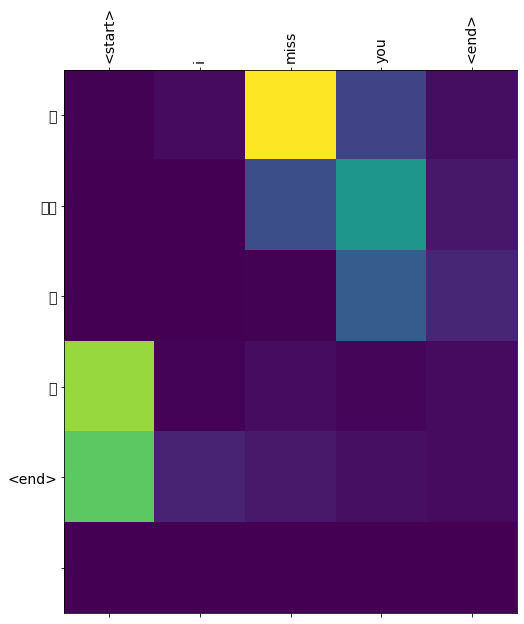

In [73]:
translate('I miss you')

## Restore the latest checkpoint and test

In [192]:
# restoring the lastest checkpoint in checkpoint_dir.
# remind that `checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)`
# after restoring, the optimzier, encoder and decoder are update to latest checkpoint values.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))